# Nesse notebook vamos melhorar pontos que o da semana passada pecou. Dentre as melhorias estão:
    > Melhoria na representação da matriz de confusão.
    > Apresentação de dados do modelo com shap.
    > Métricas do modelo (accuracy, precision, recall e fbeta score).
    > Testes com n-gramas.
    > Outros modelos para tentar melhorar os resultados.

### Imports usados no código

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# plotar de gráficos
import seaborn as sn
from matplotlib import pyplot as plt
import shap

#stemmer
from nltk.stem.snowball import SnowballStemmer

# métricas usadas
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


# modelos que foram usados para testar resultados
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

import numpy as np

### Lendo o arquivo que vamos analisar. Note que já aplicamos a label (-1 -> Negativo; 0 -> Neutro; 1 -> Positivo).

In [2]:
twets = pd.read_csv('avaliText.csv')

twets

,avaliacao,twet,class_label
0,neutral,what said.,0
1,positive,plus you've added commercials to the experien...,1
2,neutral,i didn't today... must mean i need to take an...,0
3,negative,"it's really aggressive to blast obnoxious ""en...",-1
4,negative,and it's a really big bad thing about it,-1
...,...,...,...
14635,positive,thank you we got on a different flight to chi...,1
14636,negative,leaving over 20 minutes late flight. no warni...,-1
14637,neutral,please bring american airlines to,0
14638,negative,"you have my money, you change my flight, and ...",-1


### Vamos agora tratar os dados afim de melhorar os resultados. Vamos remover stop-words e stemmizar.

In [3]:
stemmer = SnowballStemmer('english')

def stemma(text):

    words = [stemmer.stem(word) for word in text.split()]
    return " ".join(words)

In [4]:
stop = stopwords.words('english')

stop.remove("no")
stop.remove("not")
stop.remove("don't")

twets['twet'] = twets['twet'].apply(stemma)

twets

,avaliacao,twet,class_label
0,neutral,what said.,0
1,positive,plus you'v ad commerci to the experience... ta...,1
2,neutral,i didn't today... must mean i need to take ano...,0
3,negative,"it realli aggress to blast obnoxi ""entertainme...",-1
4,negative,and it a realli big bad thing about it,-1
...,...,...,...
14635,positive,thank you we got on a differ flight to chicago.,1
14636,negative,leav over 20 minut late flight. no warn or com...,-1
14637,neutral,pleas bring american airlin to,0
14638,negative,"you have my money, you chang my flight, and do...",-1


### Para instanciar a bag-of-words iremos usar TfidfVectorizer, por que acho que é o mais adequado para não dar ênfase palavras que aparecem com muita frequência agrupadas, note também que estamos removendo as stop-words aqui.

In [5]:
tfidf = TfidfVectorizer(ngram_range=(1,1),stop_words=stop)

### E vamos separar nossos dados em conjuntos para treinamento e teste.

In [6]:
text = twets['twet'].tolist()

classe = twets['class_label'].tolist()

xtrain, ytest, xright, yright = train_test_split(text,classe,random_state=4)

xtrain_matriz = tfidf.fit_transform(xtrain)
ytest_matriz = tfidf.transform(ytest)

In [7]:
xtrain_matriz.shape

(10980, 9184)

### Treinaremos uma regressão logistica primeiro, assim como na semana passada. As novidades serão como apresentar os resultados para análise.

In [8]:
model = LogisticRegression(solver='newton-cg',multi_class='multinomial')

model.fit(xtrain_matriz,xright)

output = model.predict(ytest_matriz)

output

array([-1, -1,  0, ..., -1, -1,  1])

### Verificamos agora as principais métricas para cada classe.

In [9]:
accuracy = accuracy_score(yright,output)
precisao,recall,fbeta,support = precision_recall_fscore_support(yright,output,labels=[-1,0,1])

print("\nAcuracia geral:",accuracy,"\n")
l = ["Negativo","Neutro","Positivo"]
for i in range(3):
    print("Metricas para:",l[i])
    print("Precisão:",precisao[i])
    print("Recall:",recall[i])
    print("F-beta:",fbeta[i])
    print()


Acuracia geral: 0.7849726775956284 

Metricas para: Negativo
Precisão: 0.8033687294031491
Recall: 0.943250214961307
F-beta: 0.8677081273482302

Metricas para: Neutro
Precisão: 0.6702898550724637
Recall: 0.4774193548387097
F-beta: 0.557648831951771

Metricas para: Positivo
Precisão: 0.8196286472148541
Recall: 0.552772808586762
F-beta: 0.6602564102564102



### Podemos ver que a menor precisao e recall está nas avaliações neutras, mas no geral as avaliações foram boas.

### E verificamos também a matriz de confusão.

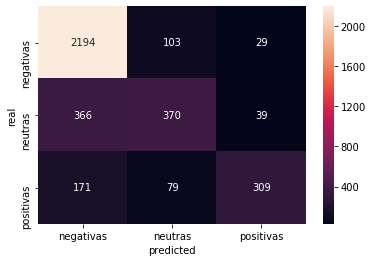

In [10]:
cm = confusion_matrix(yright,output)

cm = pd.DataFrame(cm,index = ["negativas","neutras","positivas"],columns = ["negativas","neutras","positivas"])

ax = sn.heatmap(cm,annot=True,fmt="d")

bottom, top = ax.get_ylim()

ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel("predicted")
plt.ylabel("real")

plt.show()

### E as palavras que tiveram mais peso na escolha das classes.

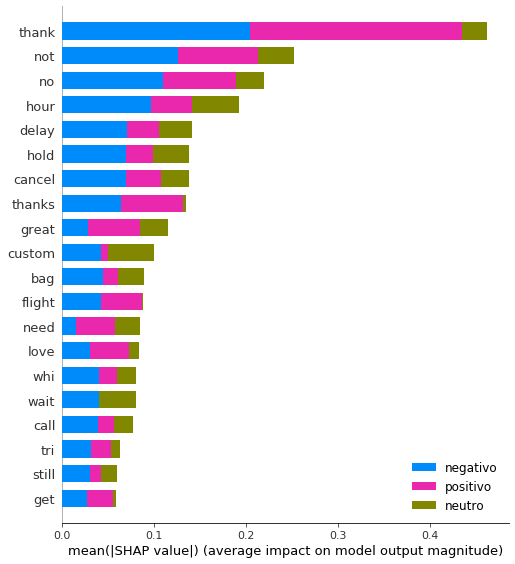

In [11]:
shap.initjs()

explainer = shap.LinearExplainer(model,xtrain_matriz,feature_dependence="independent")

shap_values = explainer.shap_values(ytest_matriz)

ytest_array = ytest_matriz.toarray()

shap.summary_plot(shap_values,ytest_array,feature_names=tfidf.get_feature_names(),class_names=["negativo","neutro","positivo"])

### Force plot do shap dando erro.

In [12]:
# ind = 0
# shap.force_plot(explainer.expected_value,shap_values[ind,:],ytest_array[ind,:],feature_names=tfidf.get_feature_names())

### Como estamos tratando de modelos lineares podemos pegar as palavras com mais peso pela matriz de coeficientes.

In [13]:
def get_most_important(cv,model,n = 10):
    dici = {v:k for k,v in cv.vocabulary_.items()}

    classes = {}

    for i in range(len(model.coef_)):
        palavras = [(dici[indice],peso) for indice,peso in enumerate(model.coef_[i])]
        palavras = sorted(palavras,key=lambda x: x[1],reverse=True)
        classes[i] = palavras[:n]

    return classes

def printa_mais_usadas(classe,lista,n=10):
    print("Classe:",classe)
    for i,j in lista:
        print(i,j)
    print()


In [14]:
dici = get_most_important(tfidf,model)

printa_mais_usadas("negativas",dici[0])

printa_mais_usadas("neutras",dici[1])

printa_mais_usadas("positivas",dici[2])


Classe: negativas
hour 3.617362584024845
not 3.5386538697040986
delay 3.11637153225956
hold 3.0958269475680145
no 3.0641586170399266
worst 2.9598187472813384
cancel 2.5578545323933617
lost 2.4157607062647535
luggag 2.342703815895398
bag 2.3346862605706264

Classe: neutras
ani 1.7195416146448261
hi 1.6909227535182385
carri 1.4717598723141292
winner 1.471743288498049
need 1.362323459295428
question 1.358515105910604
possibl 1.2756759483994728
tomorrow 1.2565694870540798
atlanta 1.2381735408315488
doe 1.2162730895999845

Classe: positivas
thank 4.78189809987213
great 4.300711624459751
love 3.7348897604673845
thanks 3.341710724119446
awesome 3.1488098910610693
best 3.1079418929386655
appreci 2.4627472448032184
thx 2.37484084088499
amazing 2.3738070113501553
excel 2.244287450981932



## Para comparar resultados vamos testar outros modelos; e para facilitar a vizualização das informações encapsulamos as métricas.

In [15]:
def get_metrics(modelo,vectorizer,treino, teste, treinoCorreto, testeCorreto):
    model = modelo

    treino_matriz = vectorizer.fit_transform(treino)
    teste_matriz = vectorizer.transform(teste)

    model.fit(treino_matriz,treinoCorreto)

    saida = model.predict(teste_matriz)

    accuracy = accuracy_score(testeCorreto,saida)
    
    precisao,recall,fbeta,support = precision_recall_fscore_support(testeCorreto,saida,labels=[-1,0,1])
    
    print("Métricas gerais para o modelo:\n")

    print("\nAcuracia geral:",accuracy,"\n")
    l = ["Negativo","Neutro","Positivo"]
    for i in range(3):
        print("Metricas para:",l[i])
        print("Precisão:",precisao[i])
        print("Recall:",recall[i])
        print("F-beta:",fbeta[i])
        print()
        
    print("Matriz de confusão")
    
    cm = confusion_matrix(testeCorreto,saida)

    cm = pd.DataFrame(cm,index = ["negativas","neutras","positivas"],columns = ["negativas","neutras","positivas"])

    ax = sn.heatmap(cm,annot=True,fmt="d")

    bottom, top = ax.get_ylim()

    ax.set_ylim(bottom + 0.5, top - 0.5)

    plt.xlabel("predicted")
    plt.ylabel("real")

    plt.show()
    
    print("Palavras mais usadas com a matriz de coeficientes\n")
    
    novo_dici = get_most_important(vectorizer,model)

    printa_mais_usadas("negativas",novo_dici[0])

    printa_mais_usadas("neutras",novo_dici[1])

    printa_mais_usadas("positivas",novo_dici[2])
    

Métricas gerais para o modelo:


Acuracia geral: 0.7849726775956284 

Metricas para: Negativo
Precisão: 0.8033687294031491
Recall: 0.943250214961307
F-beta: 0.8677081273482302

Metricas para: Neutro
Precisão: 0.6702898550724637
Recall: 0.4774193548387097
F-beta: 0.557648831951771

Metricas para: Positivo
Precisão: 0.8196286472148541
Recall: 0.552772808586762
F-beta: 0.6602564102564102

Matriz de confusão


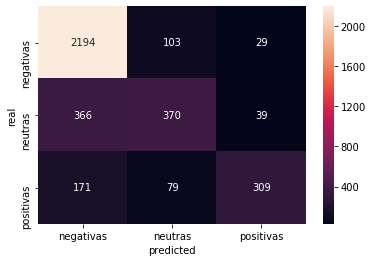

Palavras mais usadas com a matriz de coeficientes

Classe: negativas
hour 3.617362584024845
not 3.5386538697040986
delay 3.11637153225956
hold 3.0958269475680145
no 3.0641586170399266
worst 2.9598187472813384
cancel 2.5578545323933617
lost 2.4157607062647535
luggag 2.342703815895398
bag 2.3346862605706264

Classe: neutras
ani 1.7195416146448261
hi 1.6909227535182385
carri 1.4717598723141292
winner 1.471743288498049
need 1.362323459295428
question 1.358515105910604
possibl 1.2756759483994728
tomorrow 1.2565694870540798
atlanta 1.2381735408315488
doe 1.2162730895999845

Classe: positivas
thank 4.78189809987213
great 4.300711624459751
love 3.7348897604673845
thanks 3.341710724119446
awesome 3.1488098910610693
best 3.1079418929386655
appreci 2.4627472448032184
thx 2.37484084088499
amazing 2.3738070113501553
excel 2.244287450981932



In [16]:
get_metrics(LogisticRegression(solver='newton-cg',multi_class='multinomial'),tfidf,xtrain, ytest, xright, yright)

### Agora vemos os resultados com n-gramas (unigramas, bigramas, trigramas) e outros modelos

In [17]:
novo_tfidf = TfidfVectorizer(ngram_range=(1,3),stop_words=stop)

In [18]:
xtrain_matriz.shape

(10980, 9184)

### Note que a matriz cresceu bastante agora que incluimos mais combinações.

### Vamos ver como a regressão logistica se comporta lidando com ngramas.

Métricas gerais para o modelo:


Acuracia geral: 0.7669398907103825 

Metricas para: Negativo
Precisão: 0.7673622990078687
Recall: 0.9643164230438521
F-beta: 0.854638978853115

Metricas para: Neutro
Precisão: 0.6984126984126984
Recall: 0.3406451612903226
F-beta: 0.45793581960104074

Metricas para: Positivo
Precisão: 0.8356545961002786
Recall: 0.5366726296958855
F-beta: 0.6535947712418301

Matriz de confusão


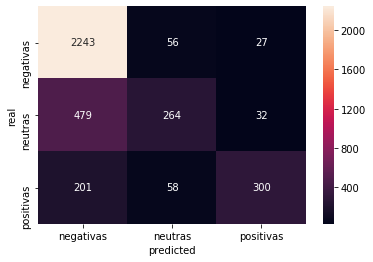

Palavras mais usadas com a matriz de coeficientes

Classe: negativas
hour 4.572240622813209
not 4.553865298960016
no 4.091466541651972
delay 3.779214653831746
hold 3.726924342600638
bag 2.9814882155045335
whi 2.717708604682065
worst 2.6728099774957466
wait 2.5998818295273303
cancel 2.4466796399706507

Classe: neutras
ani 2.242965511562327
hi 1.9441713716088298
dm 1.869462725167316
tomorrow 1.7263714469270826
need 1.6487483792047766
question 1.4184274457325807
winner 1.357545022143882
fleek 1.3494601878661663
pleas 1.289599254434474
dmed 1.2608841296526214

Classe: positivas
thank 5.561529254767108
great 5.453677202760383
love 4.391055673952905
best 3.5950243346998065
thanks 3.5068876826304547
awesome 2.8449135525405596
appreci 2.7099040734679196
good 2.2225616042280127
thx 2.1340090063162096
awesom 2.119510924774962



In [19]:
get_metrics(LogisticRegression(solver='newton-cg',multi_class='multinomial'),novo_tfidf,xtrain, ytest, xright, yright)

### Quando passamos a utilizar n-gramas a acuracia caiu! (e as métricas da classe neutra tamém) esse é um fato podemos inspecionar depois. Vamos ver como outros modelos se comportam.

### Vamos testar uma suport-vector-machine com função linear.

Métricas gerais para o modelo:


Acuracia geral: 0.7860655737704918 

Metricas para: Negativo
Precisão: 0.8026363969242036
Recall: 0.942390369733448
F-beta: 0.866917144552106

Metricas para: Neutro
Precisão: 0.692
Recall: 0.4464516129032258
F-beta: 0.5427450980392157

Metricas para: Positivo
Precisão: 0.7902097902097902
Recall: 0.6064400715563506
F-beta: 0.6862348178137652

Matriz de confusão


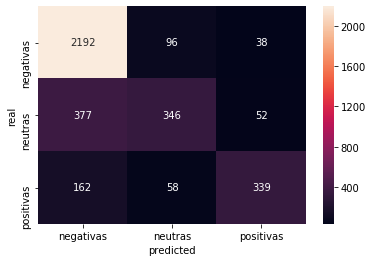

Palavras mais usadas com a matriz de coeficientes

Classe: negativas
not 3.5412945755917176
hour 3.4040641891781003
no 3.015473902416099
delay 2.997107658209951
hold 2.9080549739940427
bag 2.533811447471403
worst 2.4494441072608373
whi 2.3977494394401497
becaus 2.327505351485572
lost 2.234191514199076

Classe: neutras
hi 2.0018040869733067
no thank 1.887089665531997
ani 1.5666542061854454
make delay 1.4759791021289823
carri 1.434744232035865
question 1.4289371064466687
tomorrow 1.4247206797925014
vega 1.331078971722448
atlanta 1.3205762156143444
possibl 1.3162450065435274

Classe: positivas
great 4.361115153755619
love 3.580753692117812
best 2.9379277725020914
awesome 2.8965853608389374
appreci 2.513090682301162
thank much 2.2479855589043134
amazing 2.2027215788850034
amaz 2.119621667222691
rock 2.0856116271283445
awesom 2.0183180308559723



In [20]:
get_metrics(LinearSVC(),novo_tfidf,xtrain, ytest, xright, yright)

### A svm se saiu bem melhor que a regressão logística quando lidamos com n-gramas, incluse tokens com bigramas aparecem como uns dos mais pesados na escolha das classes. Mas os tuites classificados como neutros ainda tem métricas muito baixas comparados com positivos e negativos.

### Vamos tentar outra forma de treinar. O sgdclassifier usa stochastic gradient descent, para treinar modelos lineares afim de otimizar o resultado.

Métricas gerais para o modelo:


Acuracia geral: 0.7844262295081967 

Metricas para: Negativo
Precisão: 0.7971119133574007
Recall: 0.9492691315563199
F-beta: 0.8665620094191522

Metricas para: Neutro
Precisão: 0.7231121281464531
Recall: 0.40774193548387094
F-beta: 0.5214521452145214

Metricas para: Positivo
Precisão: 0.7660044150110376
Recall: 0.6207513416815742
F-beta: 0.6857707509881423

Matriz de confusão


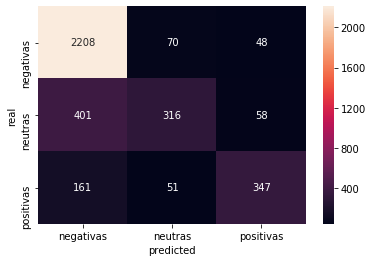

Palavras mais usadas com a matriz de coeficientes

Classe: negativas
not 4.562132603076969
hour 3.874496634767069
no 3.8473142959444893
delay 3.8301092653609197
hold 3.2919510117382953
bag 3.1473242407321123
whi 2.9909856817383886
becaus 2.7165486646152384
worst 2.711036983758368
lost 2.5454622985634674

Classe: neutras
hi 2.621117229272571
ani 2.15393413311883
dm 1.9529911548258598
no thank 1.8859642481882537
atlanta 1.8004014694409363
vega 1.7947548205091917
question 1.7323144307107579
tomorrow 1.7022442086150011
winner 1.6922995556578715
carri 1.5712369388763743

Classe: positivas
thank 5.5036198476800005
great 4.898958959809155
love 4.334600375500029
best 3.3932105383261315
awesome 3.377479817611897
thanks 2.905100187190222
appreci 2.890046428722906
amazing 2.651545534779721
awesom 2.4962257016405074
amaz 2.4093073336237825



In [21]:
get_metrics(SGDClassifier(),novo_tfidf,xtrain, ytest, xright, yright)

### Obtivemos resultados bem parecidos com a svm

### Como a svm teve os resultados ligeiramente melhores que os outros, tentamos hiperparametrizar na esperança de melhorar ainda mais os resultados.

Métricas gerais para o modelo:


Acuracia geral: 0.7882513661202186 

Metricas para: Negativo
Precisão: 0.815205118554761
Recall: 0.9312123817712812
F-beta: 0.8693558097531607

Metricas para: Neutro
Precisão: 0.6772983114446529
Recall: 0.46580645161290324
F-beta: 0.5519877675840978

Metricas para: Positivo
Precisão: 0.7617021276595745
Recall: 0.6404293381037567
F-beta: 0.6958211856171039

Matriz de confusão


/home/matheus/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


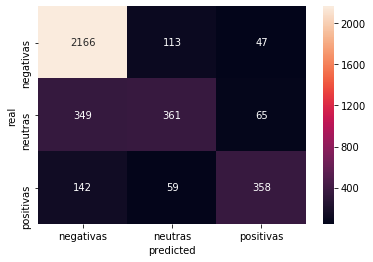

Palavras mais usadas com a matriz de coeficientes

Classe: negativas
not 2.109742257743538
hour 2.0728823462279045
hold 1.7999827843313265
delay 1.7804002094482254
no 1.744150954947462
worst 1.5335652889022342
bag 1.4888512272380892
whi 1.4591583441412161
noth 1.3797943420336785
lost 1.3661016536057402

Classe: neutras
hi 1.1618821942896178
carri 0.9774247057609445
no thank 0.946736150225145
ani 0.9222142490915645
found flight 0.8829455432328408
like one 0.8762656030326096
atlanta 0.8750438919533579
question 0.8750404503188006
amp plane 0.8535456782224133
get one 0.846414762492455

Classe: positivas
great 2.4328885855499323
love 2.1643131028007976
thank 2.081818116539334
awesome 1.7463244350815856
best 1.6551533727008152
appreci 1.4926360179171883
thanks 1.4861758422960538
amazing 1.3832226636146903
thx 1.2783920303305072
excel 1.2677876104016903



In [36]:
get_metrics(LinearSVC(loss="hinge",multi_class="crammer_singer",max_iter=1000000000),novo_tfidf,xtrain, ytest, xright, yright)

### Obtivemos um ganho na acuracia de 0.02! (o que não é muita coisa), então a melhor opção por agora é voltar para trás e tentar melhorar mais a qualidade dos nossos dados, tentando limpa-los.